# EEGDash example for sex classification

The code below provides an example of using the *EEGDash* library in combination with PyTorch to develop a deep learning model for detecting sex in a collection of 136 subjects.

1. **Data Retrieval Using EEGDash**: An instance of *EEGDashDataset* is created to search and retrieve resting state data for 136 subjects (dataset ds005505). At this step, only the metadata is transferred.

2. **Data Preprocessing Using BrainDecode**: This process preprocesses EEG data using Braindecode by selecting specific channels, resampling, filtering, and extracting 2-second epochs. This takes about 2 minutes.

3. **Creating a train and testing sets**: The dataset is split into training (80%) and testing (20%) sets with balanced labels--making sure also that we have as many males as females--converted into PyTorch tensors, and wrapped in DataLoader objects for efficient mini-batch training.

4. **Model Definition**: The model is a custom convolutional neural network with 24 input channels (EEG channels), 2 output classes (male and female).

5. **Model Training and Evaluation Process**: This section trains the neural network, normalizes input data, computes cross-entropy loss, updates model parameters, and evaluates classification accuracy over six epochs. This takes less than 10 seconds to a couple of minutes, depending on the device you use.



## Data Retrieval Using EEGDash

First we find one resting state dataset for a collection of subject. The dataset ds005505 contains 136 subjects with both male and female participants.

In [10]:
from eegdash import EEGDashDataset

ds_sexdata = EEGDashDataset(
    {"dataset": "ds005505", "task": "RestingState"}, target_name="sex"
)

## Data Preprocessing Using Braindecode

[BrainDecode](https://braindecode.org/stable/install/install.html) is a specialized library for preprocessing EEG and MEG data. 

We apply three preprocessing steps in Braindecode:
1.	**Selection** of 24 specific EEG channels from the original 128.
2.	**Resampling** the EEG data to a frequency of 128 Hz.
3.	**Filtering** the EEG signals to retain frequencies between 1 Hz and 55 Hz.

When calling the **preprocess** function, the data is retrieved from the remote repository.

Finally, we use **create_windows_from_events** to extract 2-second epochs from the data. These epochs serve as the dataset samples.

In [ ]:
from braindecode.preprocessing import (
    preprocess,
    Preprocessor,
    create_fixed_length_windows,
)
import os

# Alternatively, if you want to include this as a preprocessing step in a Braindecode pipeline:
preprocessors = [
    Preprocessor(
        "pick_channels",
        ch_names=[
            "E22",
            "E9",
            "E33",
            "E24",
            "E11",
            "E124",
            "E122",
            "E29",
            "E6",
            "E111",
            "E45",
            "E36",
            "E104",
            "E108",
            "E42",
            "E55",
            "E93",
            "E58",
            "E52",
            "E62",
            "E92",
            "E96",
            "E70",
            "Cz",
        ],
    ),
    Preprocessor("resample", sfreq=128),
    Preprocessor("filter", l_freq=1, h_freq=55),
]
preprocess(
    ds_sexdata, preprocessors, n_jobs=-1
)  # , save_dir='xxxx'' will save and set preload to false

# extract windows and save to disk
windows_ds = create_fixed_length_windows(
    ds_sexdata,
    start_offset_samples=0,
    stop_offset_samples=None,
    window_size_samples=256,
    window_stride_samples=256,
    drop_last_window=True,
    preload=False,
)
os.makedirs("data/hbn_preprocessed_restingstate", exist_ok=True)
windows_ds.save("data/hbn_preprocessed_restingstate", overwrite=True)

## Plotting a Single Channel for One Sample

It’s always a good practice to verify that the data has been properly loaded and processed. Here, we plot a single channel from one sample to ensure the signal is present and looks as expected.

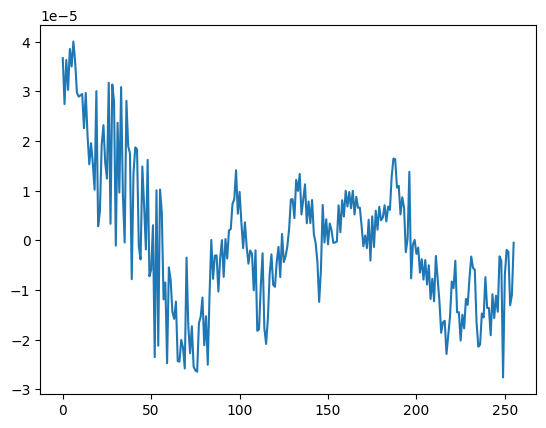

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(windows_ds[1000][0][0, :].transpose())  # first channel of first epoch
plt.show()

## Load pre-saved data

If you have run the previous steps before, the data should be saved and may be reloaded here. If you are simply running this notebook for the first time, there is no need to reload the data, and this step may be skipped. However, it is quick, so you might as well execute the cell; it will have no consequences and will allow you to check that the data was saved properly.

In [14]:
from braindecode.datautil import load_concat_dataset

print("Loading data from disk")
windows_ds = load_concat_dataset(
    path="data/hbn_preprocessed_restingstate", preload=False
)

Loading data from disk


## Creating a Training and Test Set

The code below creates a training and test set. We first split the data using the **train_test_split** function and then create a **TensorDataset** for both sets.

1. **Set Random Seed** – The random seed is fixed using `torch.manual_seed(random_state)` to ensure reproducibility in dataset splitting and model training.
2. **Get Balanced Indices for Male and Female Subjects** – We ensure a 50/50 split of male and female subjects in both the training and test sets. Additionally, we prevent subject leakage, meaning the same subjects do not appear in both sets. The dataset is split into training (90%) and testing (10%) subsets using `train_test_split()`, ensuring balanced stratification based on gender.
3. **Convert Data to PyTorch Tensors** – The selected training and testing samples are converted into `FloatTensor` for input features and `LongTensor` for labels, making them compatible with PyTorch models.
4. **Create DataLoaders** – The datasets are wrapped in PyTorch `DataLoader` objects with a batch size of 100, allowing efficient mini-batch training and shuffling. Although there are only 136 subjects, the dataset contains more than 10,000 2-second samples.


In [15]:
from braindecode.datasets import BaseConcatDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
import torch

# random seed for reproducibility
random_state = 0
np.random.seed(random_state)
torch.manual_seed(random_state)

# Get balanced indices for male and female subjects and create a balanced dataset
male_subjects = windows_ds.description["subject"][windows_ds.description["sex"] == "M"]
female_subjects = windows_ds.description["subject"][
    windows_ds.description["sex"] == "F"
]
n_samples = min(len(male_subjects), len(female_subjects))
balanced_subjects = np.concatenate(
    [male_subjects[:n_samples], female_subjects[:n_samples]]
)
balanced_gender = ["M"] * n_samples + ["F"] * n_samples
train_subj, val_subj, train_gender, val_gender = train_test_split(
    balanced_subjects,
    balanced_gender,
    train_size=0.9,
    stratify=balanced_gender,
    random_state=random_state,
)

# Create datasets
train_ds = BaseConcatDataset(
    [ds for ds in windows_ds.datasets if ds.description.subject in train_subj]
)
val_ds = BaseConcatDataset(
    [ds for ds in windows_ds.datasets if ds.description.subject in val_subj]
)

# Create dataloaders
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=100, shuffle=True)

# Check the balance of the dataset
assert len(balanced_subjects) == len(balanced_gender)
print(f"Number of subjects in balanced dataset: {len(balanced_subjects)}")
print(
    f"Gender distribution in balanced dataset: {np.unique(balanced_gender, return_counts=True)}"
)

Number of subjects in balanced dataset: 92
Gender distribution in balanced dataset: (array(['F', 'M'], dtype='<U1'), array([46, 46]))


# Check labels

It is good practice to verify the labels and ensure the random seed is functioning correctly. If all labels are 'M' (male) or 'F' (female), it could indicate an issue with data loading or stratification, requiring further investigation.

In [16]:
# get the first batch to check the labels
dataiter = iter(train_loader)
first_item, label, sz = dataiter.__next__()
np.array(label).T

array(['F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F',
       'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M',
       'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'F',
       'F', 'M', 'M', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'F',
       'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'M',
       'F', 'F', 'F', 'M', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'M', 'M',
       'F', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F',
       'F', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'M'], dtype='<U1')

# Create model

The model is a custom convolutional neural network with 24 input channels (EEG channels), 2 output classes (male vs. female), and an input window size of 256 samples (2 seconds of EEG data). See the reference below for more information.

[1] Truong, D., Milham, M., Makeig, S., & Delorme, A. (2021). Deep Convolutional Neural Network Applied to Electroencephalography: Raw Data vs Spectral Features. IEEE Engineering in Medicine and Biology Society. Annual International Conference, 2021, 1039–1042. https://doi.org/10.1109/EMBC46164.2021.9630708



In [17]:
# create model
from torchinfo import summary
from torch import nn

model = nn.Sequential(
    # First VGG block
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # Second VGG block
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # Third VGG block
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # Flatten and FC layers
    nn.Flatten(),
    nn.Linear(64 * 3 * 32, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 2),
)

print(summary(model, input_size=(1, 1, 24, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 24, 256]          160
├─ReLU: 1-2                              [1, 16, 24, 256]          --
├─Conv2d: 1-3                            [1, 16, 24, 256]          2,320
├─ReLU: 1-4                              [1, 16, 24, 256]          --
├─MaxPool2d: 1-5                         [1, 16, 12, 128]          --
├─Conv2d: 1-6                            [1, 32, 12, 128]          4,640
├─ReLU: 1-7                              [1, 32, 12, 128]          --
├─Conv2d: 1-8                            [1, 32, 12, 128]          9,248
├─ReLU: 1-9                              [1, 32, 12, 128]          --
├─MaxPool2d: 1-10                        [1, 32, 6, 64]            --
├─Conv2d: 1-11                           [1, 64, 6, 64]            18,496
├─ReLU: 1-12                             [1, 64, 6, 64]            --
├

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


# Model Training and Evaluation Process

This section trains the neural network using the Adamax optimizer, normalizes input data, computes cross-entropy loss, updates model parameters, and tracks accuracy across six epochs.

1. **Set Up Optimizer and Learning Rate Scheduler** – The `Adamax` optimizer initializes with a learning rate of 0.002 and weight decay of 0.001 for regularization.  

2. **Allocate Model to Device** – The model moves to the specified device (CPU, GPU, or MPS for Mac silicon) to optimize computation efficiency.  

3. **Normalize Input Data** – The `normalize_data` function standardizes input data by subtracting the mean and dividing by the standard deviation along the time dimension before transferring it to the appropriate device.  

4. **Train the Model for Two Epochs** – The training loop iterates through data batches with the model in training mode. It normalizes inputs, computes predictions, calculates cross-entropy loss, performs backpropagation, updates model parameters, and steps the learning rate scheduler. It tracks correct predictions to compute accuracy.  

5. **Evaluate on Test Data** – After each epoch, the model runs in evaluation mode on the test set. It computes predictions on normalized data and calculates test accuracy by comparing outputs with actual labels.  


In [18]:
from torch.nn import functional as F

optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model.to(device=device)


def normalize_data(x):
    x = x.reshape(x.shape[0], 1, 24, 256)
    mean = x.mean(dim=3, keepdim=True)
    std = x.std(dim=3, keepdim=True) + 1e-7  # add small epsilon for numerical stability
    x = (x - mean) / std
    x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
    return x


# dictionary of genders for converting sample labels to numerical values
gender_dict = {"M": 0, "F": 1}

epochs = 2
for e in range(epochs):
    # training
    correct_train = 0
    for t, (x, y, sz) in enumerate(train_loader):
        model.train()  # put model to training mode
        scores = model(normalize_data(x))
        _, preds = scores.max(1)
        y = torch.tensor(
            [gender_dict[gender] for gender in y], device=device, dtype=torch.long
        )
        correct_train += (preds == y).sum() / len(train_ds)

        # Calculates the cross-entropy loss and performs backpropagation
        loss = F.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if t % 50 == 0:
            print("Epoch %d, Iteration %d, loss = %.4f" % (e, t, loss.item()))

    # validation
    correct_test = 0
    for t, (x, y, sz) in enumerate(val_loader):
        model.eval()  # put model to testing mode
        scores = model(normalize_data(x))
        _, preds = scores.max(1)
        y = torch.tensor(
            [gender_dict[gender] for gender in y], device=device, dtype=torch.long
        )
        correct_test += (preds == y).sum() / len(val_ds)

    print(
        f"Epoch {e}, Train accuracy: {correct_train:.2f}, Test accuracy: {correct_test:.2f}\n"
    )

Epoch 0, Iteration 0, loss = 0.6941
Epoch 0, Iteration 50, loss = 0.5182
Epoch 0, Iteration 100, loss = 0.3757
Epoch 0, Iteration 150, loss = 0.2008
Epoch 0, Train accuracy: 0.78, Test accuracy: 0.77

Epoch 1, Iteration 0, loss = 0.2040
Epoch 1, Iteration 50, loss = 0.1864
Epoch 1, Iteration 100, loss = 0.2445
Epoch 1, Iteration 150, loss = 0.1083
Epoch 1, Train accuracy: 0.92, Test accuracy: 0.78

